# Preprocess PBMC from 10x

PREREQUISITE: You must first process the TCGA data using the notebook process_pbmc.ipynb. This is because we need to get the recount the fragments in the PBMC dataset USING the promoter regions called in the TCGA dataset.

tutorial followed: https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/pbmc10k/1-Gene-Expression-Processing.html


data downloaded from: https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/1.0.0/pbmc_granulocyte_sorted_10k?



In [1]:
# imports

import os

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

import muon as mu
from muon import atac as ac


2024-04-12 14:36:50.579270: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 14:36:50.580283: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 14:36:50.601161: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 14:36:50.601733: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 14:36:50.943383: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
# load / write intermediate files

data_path = f"{os.getcwd()}/../data/"

results_file = f"{data_path}/PBMC/pbmc10k_processed.h5ad"

# get TCGA regions
tcga_file = f"{data_path}/TCGA/tcga_atac_promoters.h5ad"
tcga_adata = ad.read_h5ad(tcga_file)

# read
mdata = mu.read_10x_h5(f"{data_path}/PBMC/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5")
mdata.var_names_make_unique()

# write
mdata.write(f"{data_path}/PBMC/pbmc10k.h5mu")

mdata

/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from /home/natalie/projects/checkouts/buddi_atac/buddi_atac/preprocessing_qc/../data//PBMC/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


MuData object with n_obs × n_vars = 11909 × 144978
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	11909 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	11909 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [3]:
# get the ATAC data

atac = mdata.mod['atac']
atac  # an AnnData object

AnnData object with n_obs × n_vars = 11909 × 108377
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

# QC ATAC counts

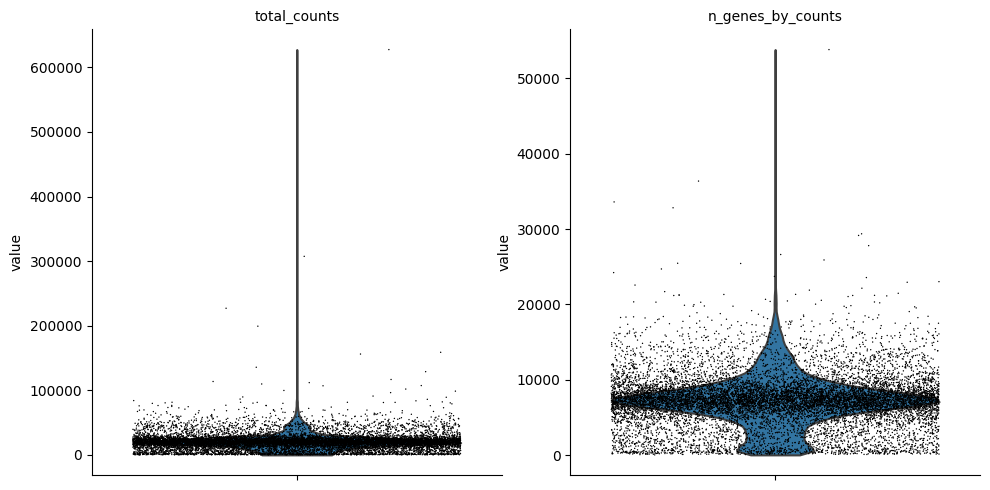

In [4]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)


In [5]:
#mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)


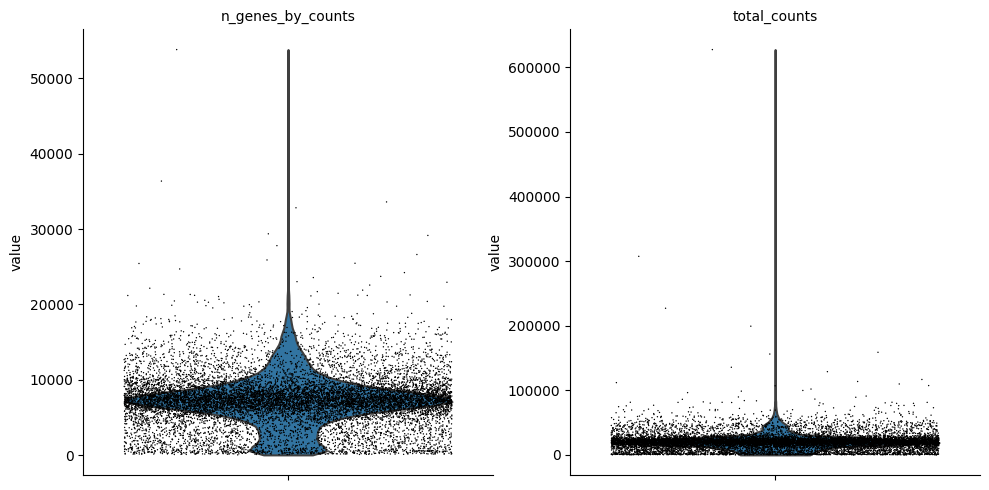

In [6]:
#mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
#mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 4000) & (x <= 40000))
sc.pl.violin(atac, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


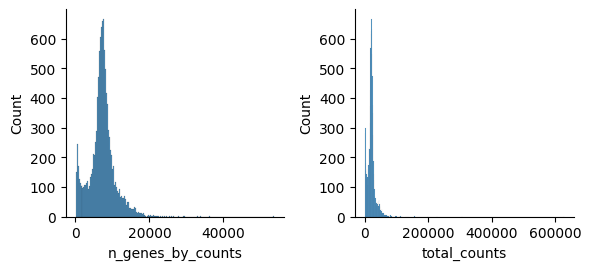

In [7]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'])


In [8]:
atac.obs['NS']=1


Fetching Regions...:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching Regions...: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


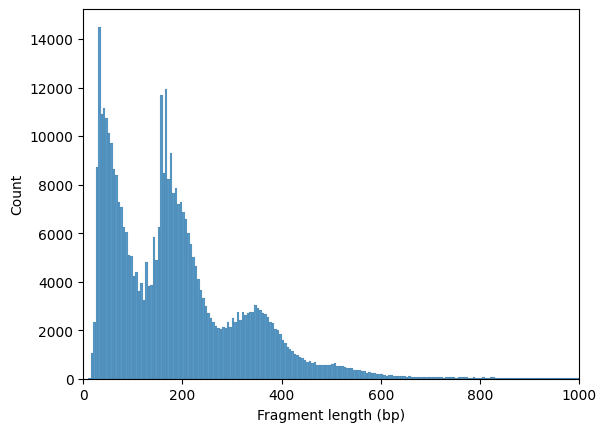

In [9]:
mu.atac.tl.locate_fragments(atac, f"{data_path}/PBMC/pbmc_granulocyte_sorted_10k_atac_fragments.tsv.gz")

ac.pl.fragment_histogram(atac, region='chr1:1-2000000')


In [10]:
ac.tl.nucleosome_signal(atac, n=1e6)


Reading Fragments: 100%|██████████| 1000000/1000000 [00:01<00:00, 677043.15it/s]


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


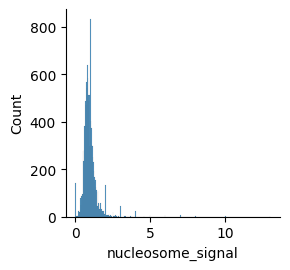

In [11]:
mu.pl.histogram(atac, "nucleosome_signal", kde=False)


# Get cell type labels from RNA

In [12]:
rna = mdata.mod['rna']


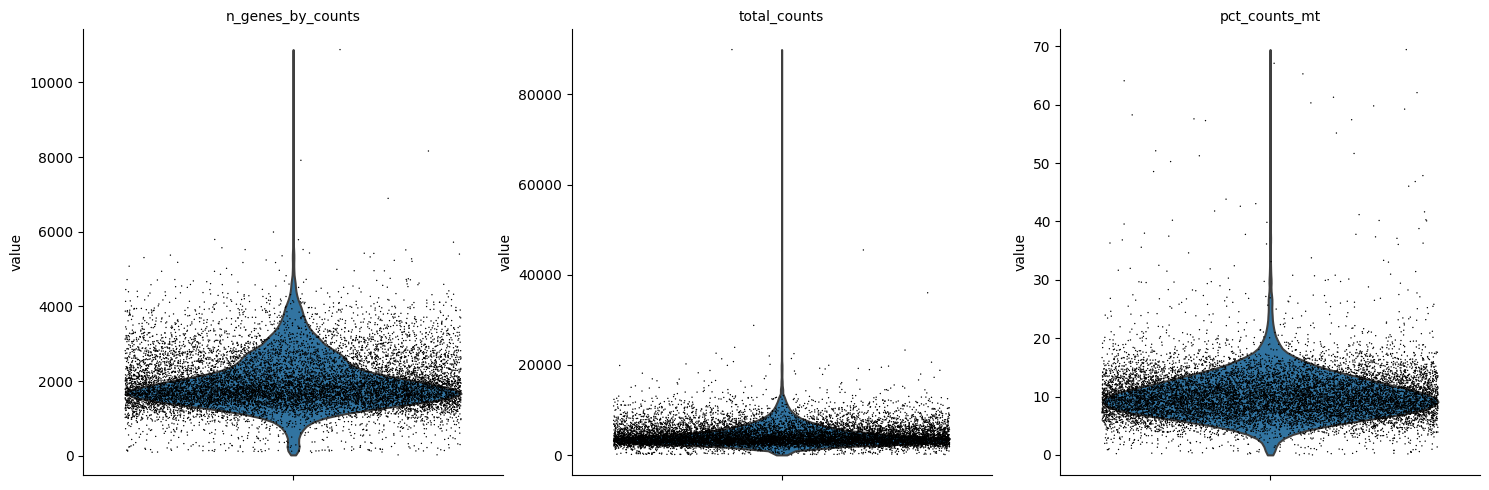

In [13]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


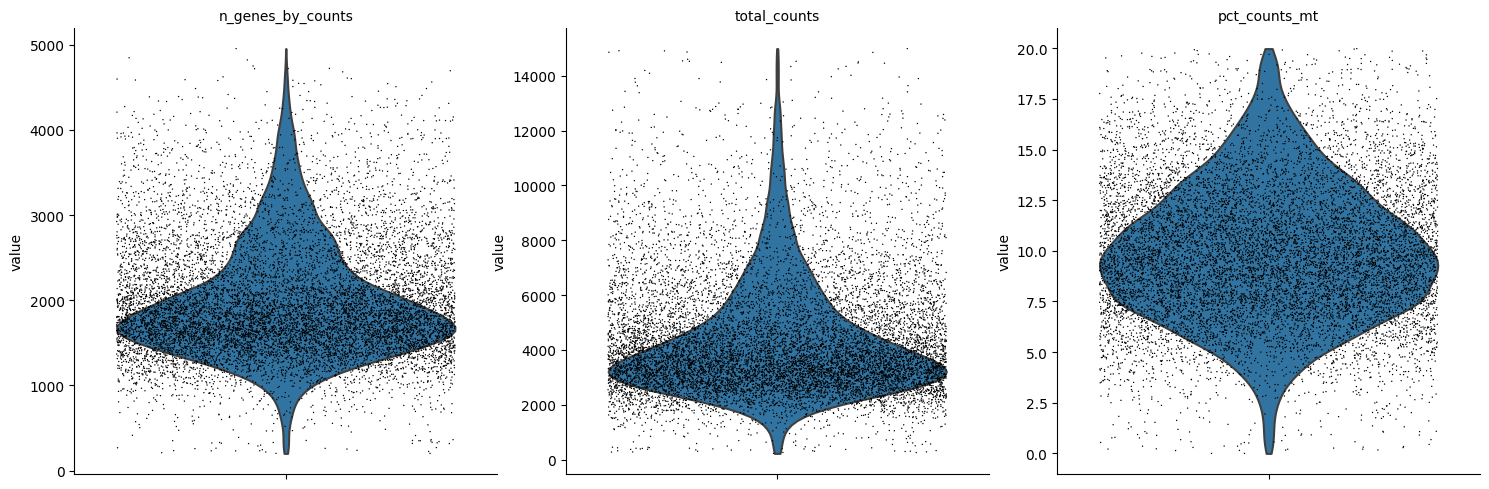

In [14]:
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))

mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 15000)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)

sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


In [15]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)


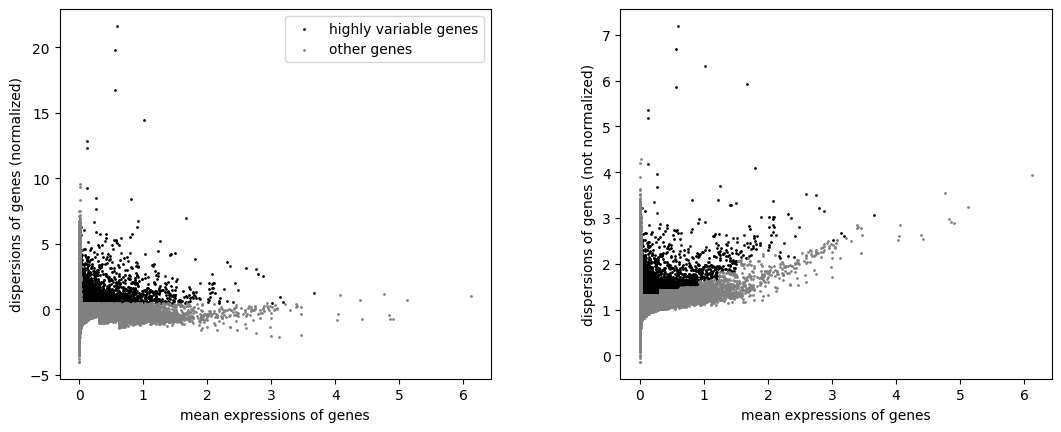

In [16]:
sc.pl.highly_variable_genes(rna)


In [17]:
np.sum(rna.var.highly_variable)


3026

In [18]:
# for visualization later
rna.raw = rna
sc.pp.scale(rna, max_value=10)


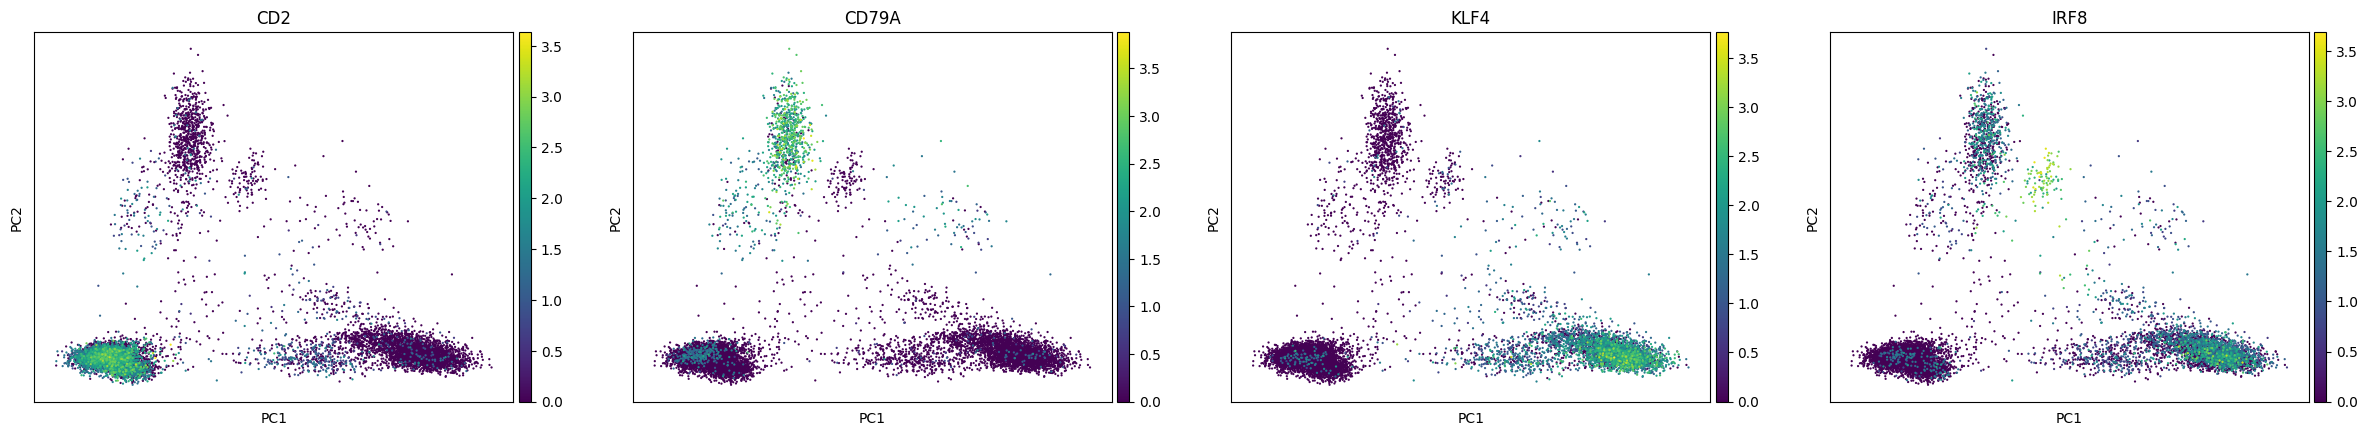

/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


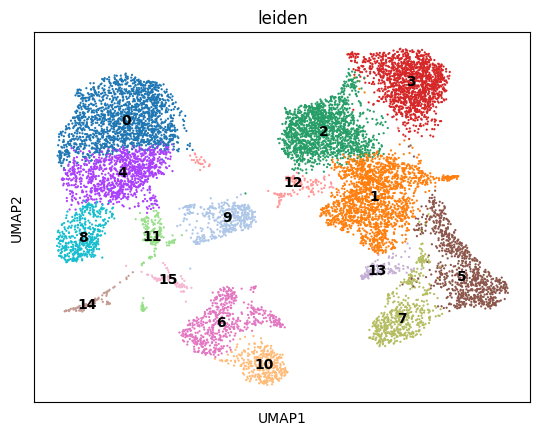

In [19]:
sc.tl.pca(rna, svd_solver='arpack')

sc.pl.pca(rna, color=['CD2', 'CD79A', 'KLF4', 'IRF8'])
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)
sc.tl.leiden(rna, resolution=.5)
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(rna, color="leiden", legend_loc="on data")


In [20]:
sc.tl.rank_genes_groups(rna, 'leiden', method='t-test')


In [21]:
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p,14_n,14_p,15_n,15_p
0,PLXDC2,0.0,INPP4B,0.000000e+00,LEF1,0.000000e+00,LEF1,0.000000e+00,SLC8A1,0.0,CCL5,0.000000e+00,BANK1,0.000000e+00,GNLY,0.000000e+00,TCF7L2,0.000000e+00,NEAT1,4.718788e-212,IGHM,1.717803e-288,CD74,1.861812e-90,RPS29,4.774914e-18,SLC4A10,2.634787e-56,TCF4,2.131729e-108,BANK1,3.763630e-47
1,VCAN,0.0,IL32,0.000000e+00,BCL11B,0.000000e+00,BACH2,0.000000e+00,AOAH,0.0,NKG7,6.546799e-264,CD74,0.000000e+00,NKG7,1.322683e-278,PSAP,0.000000e+00,PLXDC2,2.628608e-182,AFF3,7.544326e-270,HLA-DPB1,2.860326e-81,RPS12,1.381090e-17,NKG7,5.384823e-49,RHEX,9.108032e-85,AFF3,3.540130e-43
2,DPYD,0.0,LTB,0.000000e+00,BACH2,0.000000e+00,PDE3B,0.000000e+00,TYMP,0.0,IL32,5.707424e-285,RALGPS2,2.564289e-316,CD247,1.510339e-282,LYN,0.000000e+00,ZEB2,7.727212e-167,BANK1,4.769343e-241,HLA-DRA,1.469805e-79,RPS27,1.739592e-15,PHACTR2,5.413405e-47,IRF8,2.498883e-83,CD74,4.056817e-40
3,ARHGAP26,0.0,SYNE2,0.000000e+00,CAMK4,0.000000e+00,THEMIS,0.000000e+00,PLXDC2,0.0,SYNE2,2.601561e-216,AFF3,1.996288e-313,PRF1,5.082465e-224,SAT1,0.000000e+00,LYST,6.523811e-153,CD74,1.556804e-232,HLA-DRB1,1.515023e-76,RPL13,3.090868e-15,RORA,8.477112e-45,FCHSD2,1.102102e-83,MARCH1,3.041276e-38
4,LRMDA,0.0,ANK3,0.000000e+00,FHIT,0.000000e+00,NELL2,0.000000e+00,NEAT1,0.0,PRKCH,6.220694e-203,MS4A1,1.361494e-278,KLRD1,2.917590e-175,MTSS1,6.945699e-299,DPYD,1.410993e-156,FCRL1,6.639308e-170,HLA-DPA1,2.345966e-74,RPS14,1.373300e-13,SYNE2,8.133897e-43,UGCG,2.849759e-78,LYN,1.349818e-37
5,NEAT1,0.0,CDC14A,0.000000e+00,MALAT1,0.000000e+00,BCL11B,0.000000e+00,DPYD,0.0,GZMA,1.998590e-175,OSBPL10,8.911798e-228,GZMA,3.913496e-171,CST3,1.766515e-289,SLC8A1,1.506366e-141,RALGPS2,3.628680e-166,AFF3,1.875145e-73,RPS26,7.540619e-12,IL7R,1.387635e-38,AFF3,3.814404e-81,HLA-DRA,1.141581e-35
6,FCN1,0.0,IL7R,0.000000e+00,RPS27A,0.000000e+00,CAMK4,0.000000e+00,JAK2,0.0,SKAP1,4.924048e-185,HLA-DRA,6.100710e-255,SYNE1,4.917205e-165,WARS,6.182526e-282,TYMP,1.073278e-145,HLA-DRA,5.218854e-177,GAPDH,9.889428e-73,RPL30,1.513359e-11,SKAP1,5.995928e-38,CD74,5.871097e-85,PLXDC2,9.282717e-33
7,ZEB2,0.0,ITGB1,5.450929e-309,TCF7,4.145895e-301,CD8B,3.667746e-319,ZEB2,0.0,A2M,9.922503e-164,CD79A,1.017956e-225,PRKCH,8.991952e-170,CTSS,5.129195e-313,LYN,1.311266e-143,BACH2,8.734902e-164,CST3,2.543704e-70,RPS21,2.386872e-11,A2M,7.309596e-37,PLD4,6.527482e-73,MEF2C,5.807982e-31
8,CSF3R,0.0,ARHGAP15,0.000000e+00,INPP4B,1.549724e-288,OXNAD1,0.000000e+00,FCN1,0.0,HLA-B,8.705346e-170,PAX5,4.409165e-221,CTSW,7.274808e-158,COTL1,5.614618e-275,FCN1,3.184474e-135,PAX5,3.466933e-149,CCDC88A,5.261336e-70,RPL28,4.803260e-11,CCL5,2.530043e-36,BCL11A,1.199668e-67,MS4A1,2.406744e-30
9,DENND1A,0.0,BCL11B,3.952525e-323,RPS27,3.948399e-311,TXK,5.115042e-310,DENND1A,0.0,SYNE1,7.294186e-161,BLK,1.280630e-195,MCTP2,1.457122e-153,TYMP,1.373831e-293,AOAH,1.301608e-141,MS4A1,3.121565e-133,HLA-DRB5,1.087053e-67,RPS18,1.212138e-10,KLRB1,6.298875e-36,RABGAP1L,1.325867e-70,PRKCB,5.573917e-30


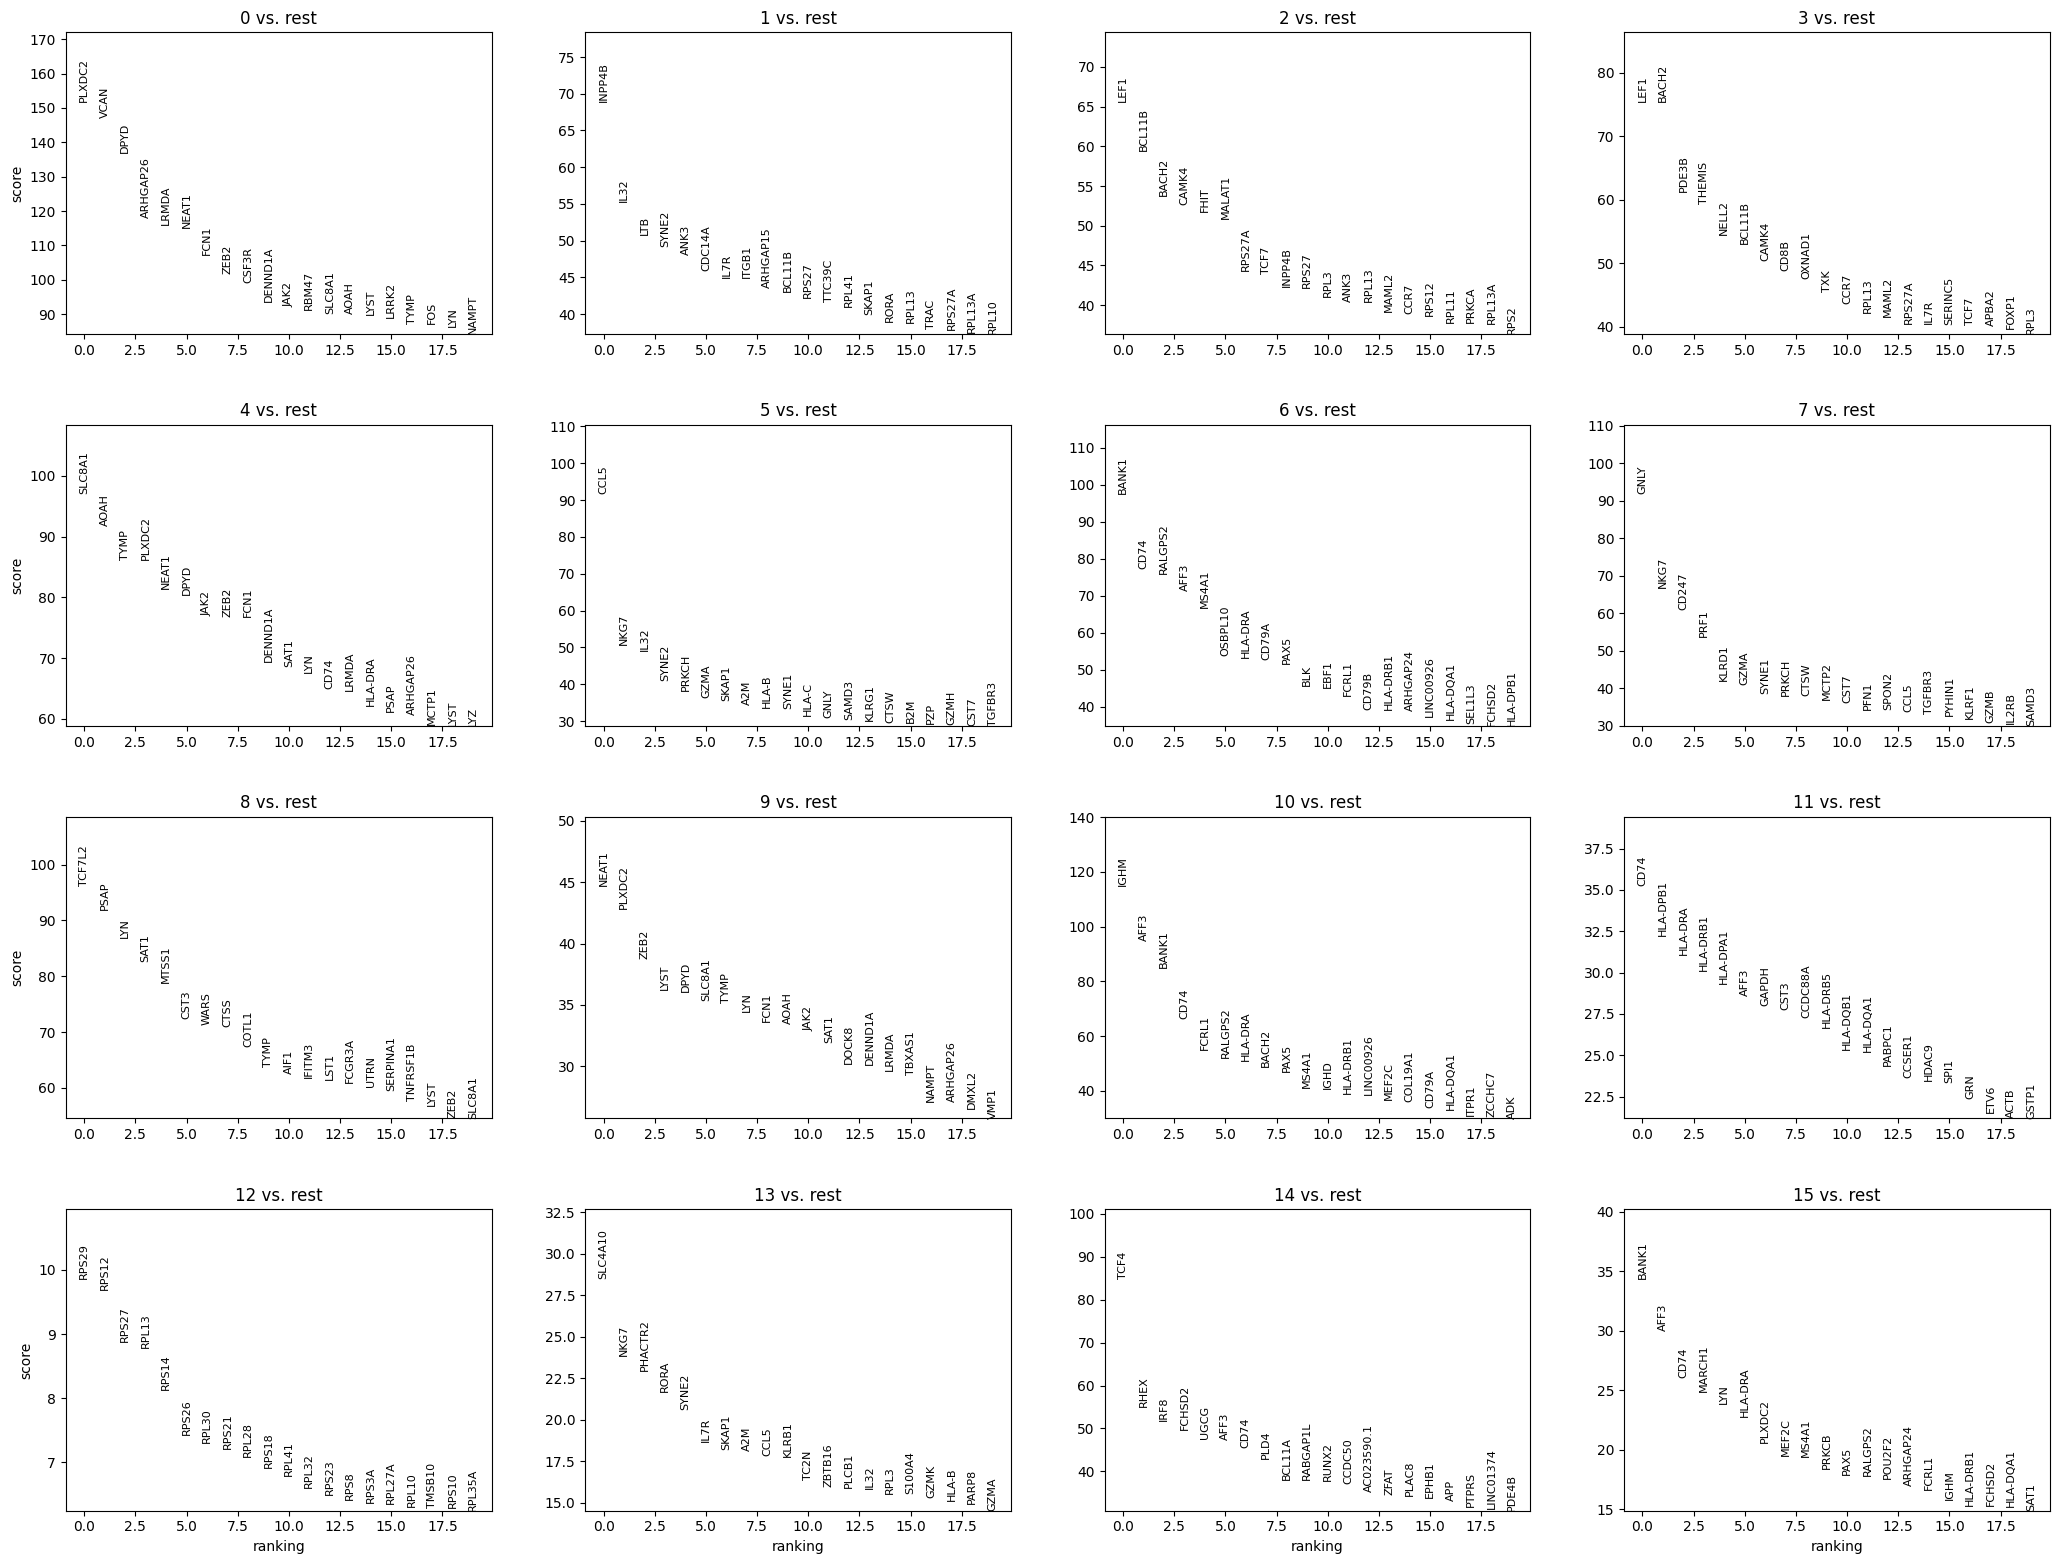

In [22]:
sc.pl.rank_genes_groups(rna, n_genes=20, sharey=False)


In [23]:


mu.pp.filter_obs(rna, "leiden", lambda x: ~x.isin(["9", "15", "12"]))

new_cluster_names = {
    "1": "CD4+ memory T", "3": "CD8+ naïve T", "2": "CD4+ naïve T",
    "5": "CD8+ activated T", "7": "NK", "13": "MAIT",
    "6": "memory B", "10": "naïve B",
    "0": "CD14 mono", "4": "intermediate mono", "8": "CD16 mono",
    "11": "mDC", "14": "pDC",
}


rna.obs['scpred_CellType'] = rna.obs.leiden.astype("str").values
rna.obs.scpred_CellType = rna.obs.scpred_CellType.astype("category")
rna.obs.scpred_CellType = rna.obs.scpred_CellType.cat.rename_categories(new_cluster_names)

rna.obs.scpred_CellType.cat.reorder_categories([
    'CD4+ naïve T', 'CD4+ memory T', 'MAIT',
    'CD8+ naïve T', 'CD8+ activated T', 'NK',
    'naïve B', 'memory B',
    'CD14 mono', 'intermediate mono', 'CD16 mono',
    'mDC', 'pDC'], inplace=True)

import matplotlib
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(rna.obs.scpred_CellType.cat.categories)))

rna.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

/tmp/ipykernel_343516/1243149094.py:16: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  rna.obs.scpred_CellType.cat.reorder_categories([


/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


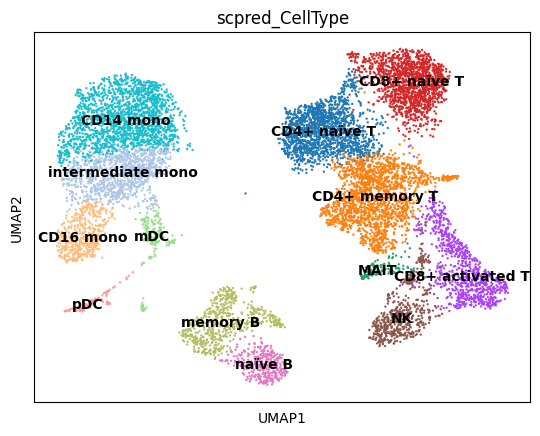

In [24]:
sc.pl.umap(rna, color="scpred_CellType", legend_loc="on data")


# Now transfer the cell type labels to the ATAC data

In [25]:
keep_ids = np.intersect1d(atac.obs.index.tolist(), rna.obs.index.tolist())

# reorder + filter
atac_filter = atac[keep_ids, :]
rna_filter = rna[keep_ids, :]

# double check that we have the same ordering
np.all(atac_filter.obs.index.to_list() == rna_filter.obs.index.to_list())


True

In [26]:
# add the cell type labels to the ATAC data
atac_filter.obs["scpred_CellType"] = rna_filter.obs['scpred_CellType']
atac_filter.obs

/tmp/ipykernel_343516/2872618316.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  atac_filter.obs["scpred_CellType"] = rna_filter.obs['scpred_CellType']


,n_genes_by_counts,total_counts,NS,nucleosome_signal,scpred_CellType
AAACAGCCAAGGAATC-1,13878,55582.0,1,1.178571,CD4+ naïve T
AAACAGCCAATCCCTT-1,7253,20495.0,1,0.769231,CD4+ memory T
AAACAGCCAATGCGCT-1,6528,16674.0,1,1.333333,CD4+ naïve T
AAACAGCCACCAACCG-1,3323,7658.0,1,0.800000,CD8+ naïve T
AAACAGCCAGGATAAC-1,4267,10355.0,1,0.562500,CD4+ naïve T
...,...,...,...,...,...
TTTGTTGGTGTTAAAC-1,6629,17869.0,1,0.638889,CD8+ naïve T
TTTGTTGGTTAGGATT-1,4267,10558.0,1,0.941176,NK
TTTGTTGGTTGCAGTA-1,150,297.0,1,0.000000,CD4+ memory T
TTTGTTGGTTGGTTAG-1,6367,17054.0,1,1.107143,CD4+ memory T


# Get promoter regions from TCGA and recount fragments


In [27]:
# get the regions of interest
region_df = tcga_adata.var
region_df = region_df.iloc[:,0:3]
region_df = region_df.rename(columns={"seqnames":"Chromosome"})
region_df

,Chromosome,start,end
0,chr1,17238,17739
20,chr1,817118,817619
24,chr1,826524,827025
25,chr1,827303,827804
26,chr1,830679,831180
...,...,...,...
562680,chrX,155767443,155767944
562686,chrX,155880523,155881024
562687,chrX,155881036,155881537
562703,chrX,156003787,156004288


In [28]:

# get fragments file
mu.atac.tl.locate_fragments(atac_filter, f"{data_path}/PBMC/pbmc_granulocyte_sorted_10k_atac_fragments.tsv.gz")
counts_pbmc = mu.atac.tl.count_fragments_features(atac_filter, region_df)

counts_pbmc.var['gene_ids'] = counts_pbmc.var.Chromosome.astype(str) + ":" + counts_pbmc.var.start.astype(str)  + "-" +  counts_pbmc.var.end.astype(str)


  0%|          | 0/45782 [00:00<?, ?it/s]

100%|██████████| 45782/45782 [03:00<00:00, 253.35it/s]
/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/muon/_atac/tools.py:867: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(X=mx, obs=adata.obs, var=features)


In [29]:
counts_pbmc.var

,Chromosome,start,end,gene_ids
0,chr1,17238,17739,chr1:17238-17739
20,chr1,817118,817619,chr1:817118-817619
24,chr1,826524,827025,chr1:826524-827025
25,chr1,827303,827804,chr1:827303-827804
26,chr1,830679,831180,chr1:830679-831180
...,...,...,...,...
562680,chrX,155767443,155767944,chrX:155767443-155767944
562686,chrX,155880523,155881024,chrX:155880523-155881024
562687,chrX,155881036,155881537,chrX:155881036-155881537
562703,chrX,156003787,156004288,chrX:156003787-156004288


In [30]:
counts_pbmc.obs

,n_genes_by_counts,total_counts,NS,nucleosome_signal,scpred_CellType
AAACAGCCAAGGAATC-1,13878,55582.0,1,1.178571,CD4+ naïve T
AAACAGCCAATCCCTT-1,7253,20495.0,1,0.769231,CD4+ memory T
AAACAGCCAATGCGCT-1,6528,16674.0,1,1.333333,CD4+ naïve T
AAACAGCCACCAACCG-1,3323,7658.0,1,0.800000,CD8+ naïve T
AAACAGCCAGGATAAC-1,4267,10355.0,1,0.562500,CD4+ naïve T
...,...,...,...,...,...
TTTGTTGGTGTTAAAC-1,6629,17869.0,1,0.638889,CD8+ naïve T
TTTGTTGGTTAGGATT-1,4267,10558.0,1,0.941176,NK
TTTGTTGGTTGCAGTA-1,150,297.0,1,0.000000,CD4+ memory T
TTTGTTGGTTGGTTAG-1,6367,17054.0,1,1.107143,CD4+ memory T


# Write out

In [31]:
counts_pbmc.write_h5ad(results_file)